In [2]:
from data_base import *

data = DataBase(summary=True, max_size=10**6)

Whole text size: 36161157 so used 1000000
Alphabet length: 160
Alphabet:  !"#%&'()*,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~§«°·»½¾ßàáâäçèéêëíîïòóôöùúûüýœ̀́γεθιλοστυώабвгдежзийклмнопрстуфхцчшщъыьэюяёєіїљќѣ‑–—’“”„…№


In [70]:
import numpy as np

def match_to_letters(prediction):
    return {data.alphabet[i]: prediction[i] for i in range(data.alph_len)}

def letter_of_pred(prediction) -> str:
    return data.alphabet[prediction.argmax()]

def sorted_need_letters(prediction, need):
    pr = match_to_letters(prediction)
    pr = list(sorted(pr.items(), key=lambda x: x[1]))
    pr = [x for x in pr if x[0] in need]
    return pr
    

class LetterCounter:
    def __init__(self):
        self.one_letter_counter = np.zeros((data.alph_len,), dtype=np.int32)
        self.counter = np.zeros((data.alph_len, data.alph_len), dtype=np.int32)

    def correlate(self, prev, next):
        prev_ind = data.letter_index[prev]
        next_ind = data.letter_index[next]
        self.one_letter_counter[prev_ind] += 1
        self.counter[prev_ind][next_ind] += 1
    
    def letter_distribution(self):
        normed_olc = self.one_letter_counter / np.sum(self.one_letter_counter)
        return match_to_letters(normed_olc)

    def predict_raw(self, prev):
        prev_ind = data.letter_index[prev]
        return self.counter[prev_ind]
    
    def predict_unif(self, prev):
        preds = self.predict_raw(prev)
        total = preds.sum()
        return preds / total
    
    def predict_next(self, prev):
        return letter_of_pred(self.predict_raw(prev))

    def get_rate(self, prev, next):
        return self.counter[data.letter_index[prev]][data.letter_index[next]]


class SimpleModel(LetterCounter):
    def __init__(self, frag_len):
        super().__init__()
        self.frag_len = frag_len
        self.counters = [LetterCounter() for _ in range(frag_len)]

    def correlate(self, prev_frag, next):
        next_ind = data.letter_index[next]

        for i in range(self.frag_len):
            prev_ind = data.letter_index[prev_frag[i]]
            self.counters[i].counter[prev_ind][next_ind] += 1
            self.counter[prev_ind][next_ind] += 1
            self.counters[i].one_letter_counter[prev_ind] += 1

    def predict_raw(self, prev_frag):
        defect = 0
        #defect = self.frag_len - len(prev_frag)
        #prev_frag = ' '*defect + prev_frag

        preds = np.zeros(data.alph_len)
        
        for i in range(defect, self.frag_len):
            preds += self.counters[i].predict_raw(prev_frag[i])

        return preds


FRAGMENT_LEN = 3
simple_model = SimpleModel(FRAGMENT_LEN)

for i in tqdm(range(FRAGMENT_LEN, data.text_size)):
    simple_model.correlate(data.whole_text[i-FRAGMENT_LEN : i], data.whole_text[i])


  0%|          | 0/999997 [00:00<?, ?it/s]

100%|██████████| 999997/999997 [00:08<00:00, 122664.15it/s]


In [71]:
import pandas as pd
import json

# Saving data

#json.dump(simple_model.counter, open('correlation data.json', 'w'))

df = pd.DataFrame(simple_model.counter, index=data.alphabet, columns=data.alphabet)
df.to_csv('data/correlation data.csv', sep='\t')

# so df.loc['а', 'в'] == df['в', 'а'] == data.whole_text.count('ав') == simple_model.counter['в']['а'] == 99253

In [72]:
need_alph = list(' абвгдеёжзийклмнопрстуфхцчшщъыьэюя.,!?-')

#data_fr = df.loc[need_alph, need_alph]
data_fr = df.loc[:, :]

data_fr.loc[need_alph, need_alph].head()

,,а,б,в,г,д,е,ё,ж,з,...,ы,ь,э,ю,я,.,",",!,?,-
,35996,26509,12578,22810,9064,15575,34789,4,4873,9469,...,6112,162,2113,1924,6387,264,1195,36,21,4568
а,31157,7962,1982,6605,1787,3692,8591,0,1719,3822,...,2526,3707,280,1323,4209,2153,5644,175,143,557
б,3978,2824,139,1082,836,1419,3906,0,614,957,...,3933,1142,40,218,1036,257,620,31,27,22
в,13406,7488,630,1931,1424,2602,12417,3,473,1318,...,2219,1576,193,843,1754,768,1757,75,45,98
г,7197,3127,546,1380,225,2191,1944,1,148,470,...,232,108,28,116,441,384,1023,30,33,173


In [73]:
print("Probability of the next one after the previous one")
next_to_prev = data_fr.div(data_fr.sum(axis=1), axis=0)
next_to_prev = next_to_prev.apply(lambda x: round(x*100, 2))
next_to_prev.loc[need_alph, need_alph].head()

Probability of the next one after the previous one


,,а,б,в,г,д,е,ё,ж,з,...,ы,ь,э,ю,я,.,",",!,?,-
,7.64,5.62,2.67,4.84,1.92,3.30,7.38,0.0,1.03,2.01,...,1.30,0.03,0.45,0.41,1.36,0.06,0.25,0.01,0.00,0.97
а,17.27,4.41,1.10,3.66,0.99,2.05,4.76,0.0,0.95,2.12,...,1.40,2.06,0.16,0.73,2.33,1.19,3.13,0.10,0.08,0.31
б,8.90,6.32,0.31,2.42,1.87,3.17,8.74,0.0,1.37,2.14,...,8.80,2.55,0.09,0.49,2.32,0.57,1.39,0.07,0.06,0.05
в,12.48,6.97,0.59,1.80,1.33,2.42,11.56,0.0,0.44,1.23,...,2.07,1.47,0.18,0.78,1.63,0.71,1.64,0.07,0.04,0.09
г,16.67,7.24,1.26,3.20,0.52,5.07,4.50,0.0,0.34,1.09,...,0.54,0.25,0.06,0.27,1.02,0.89,2.37,0.07,0.08,0.40


C:\Users\CA81~1\AppData\Local\Temp/ipykernel_27820/1628655845.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


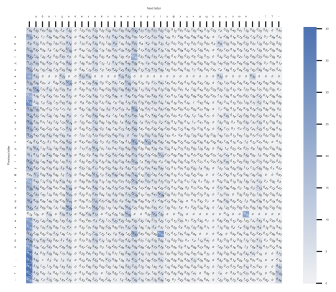

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

sns.set_context('notebook')
sns.set_style("ticks")

sns.set(font_scale=0.25)

ax = sns.heatmap(next_to_prev.loc[need_alph, need_alph],
                 annot=True, fmt='g', annot_kws={'rotation': -30},
                 square=True, xticklabels=True, yticklabels=True,
                 cmap=sns.color_palette("light:b", as_cmap=True))

ax.xaxis.tick_top()
ax.set(ylabel="Previous letter")
ax.set_title("Next letter")
plt.tight_layout()
plt.show()

In [75]:
letters_predicted = 0
predictability = 0
n = 100_000
#n = data.text_size

for i in tqdm(range(FRAGMENT_LEN, n)):
    text_fragment = data.whole_text[i-FRAGMENT_LEN : i]

    predictability += match_to_letters(simple_model.predict_unif(text_fragment))[data.whole_text[i]]
    letters_predicted += 1 if simple_model.predict_next(text_fragment) == data.whole_text[i] else 0

predictability /= n - FRAGMENT_LEN
letters_predicted /= n - FRAGMENT_LEN
print('Predicted ', round(letters_predicted*100, 2), '% of letters')
print('Predictability of russian language is', round(predictability*100, 2), '%')
    

100%|██████████| 99997/99997 [00:06<00:00, 15822.83it/s]

Predicted  19.98 % of letters
Predictability of russian language is 8.43 %


In [76]:
#test_text = 'приветики, съешь ещё этих мягких французских булочек да выпей чаю'
#test_text = 'и снова седая ночь, и только ей доверяю я, знаешь седая ночь что-то та-а-ам'
#test_text = 'мне нужно это предложение, чтобы протестировать некий анализ йей!'
#test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы – следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт – то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")
test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы - следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт - то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")

r = test_text[:FRAGMENT_LEN]
for i in range(FRAGMENT_LEN, len(test_text)):
    #if match_to_letters(simple_model.predict_unif(test_text[i-FRAGMENT_LEN : i]))[test_text[i]] > 0.09 and test_text[i] != ' ':
    if match_to_letters(simple_model.predict_unif(r[-FRAGMENT_LEN:]))[test_text[i]] > 0.07 and test_text[i] != ' ':
    #if simple_model.predict_next(test_text[i-FRAGMENT_LEN : i]) == test_text[i] and test_text[i] != ' ':
    #if simple_model.predict_next(r[-FRAGMENT_LEN:]) == test_text[i] and test_text[i] != ' ':
        r += ''
    else:
        r += test_text[i]

print(r)
print('Original length:', len(test_text))
print('Compressed length:', len(r))
print('Compression:', len(r) / len(test_text))

есл псмтрть из чг олучся оригнльня мысль, т мжм ыдлть лдующ фктры: личные цннси, культурный опыт, ерспктив и взгляд а мир, эмционльны и интуитвны кмпннты. из этг и кладывтся индивдуаьнсь тврца-члвк. ии е бладт эмциям. о чт из этг е мжт быт имитрван? он н мжт облдт ичм из ерчислннг, едь эт е писущ живым и мыслящм ущсвм, а ии е живй; однк он мжт е эт итат и вссздт  сб. эти фктры - лдсв ег пжитг, ег акплнг и тпчааннг опыт. а впитывть опыт - т, ч ии и длают и псбны длат эт лучш ас и в грзд бльшм объем, чм осбны люд, едь ии е рганчн физиолгичскми фктрми.
Original length: 734
Compressed length: 555
Compression: 0.7561307901907357


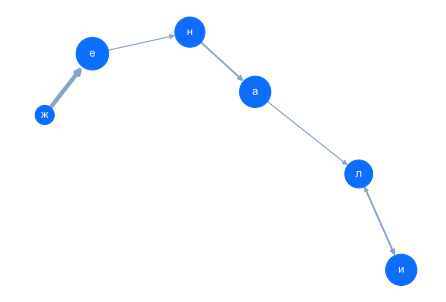

In [90]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph(directed=True)

need_symbs = 'йцукенгшщзхъфывапролджэячсмитьбюё'

current_node = 'ж'
i = 0
while i < 10:
	pred = simple_model.counters[-1].predict_unif(current_node)
	pred = sorted_need_letters(pred, need_symbs)
	b = pred[-1][0]

	w = pred[-1][1]*10

	g.add_edge(current_node, b, weight=w)

	current_node = b
	i += 1

weights = [g[u][v]['weight'] for u, v in g.edges]

letter_counts = simple_model.counters[-1].letter_distribution()

node_sizes = [letter_counts[v[0]]**0.5 * 4000 for v in g.degree]

options = {
    'node_color': '#0d6efd',
    'font_color': '#fff',
    'edge_color': '#89a4cb',
    'font_size': 11, 
}

nx.draw(g, with_labels=True, width=weights, node_size=node_sizes, arrows=True, **options)

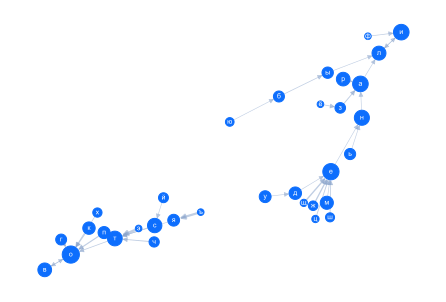

In [102]:
g = nx.DiGraph(directed=True)

for l in need_symbs:
	pred = simple_model.counters[-1].predict_unif(l)
	pred = sorted_need_letters(pred, need_symbs)

	p = pred[-1]
	a = p[0]
	w = min(max(p[1], 0.2), 0.8) * 3

	g.add_edge(l, a, weight=w)

weights = [g[u][v]['weight'] for u, v in g.edges]
node_sizes = [max(letter_counts[v[0]], 0.002)**0.5 * 1000 for v in g.degree]

options = {
    'node_color': '#0d6efd',
    'font_color': '#fff',
    'edge_color': '#89a4cb88',
    'font_size': 7, 
}

nx.draw(g, with_labels=True, width=weights, node_size=node_sizes, arrows=True, **options)

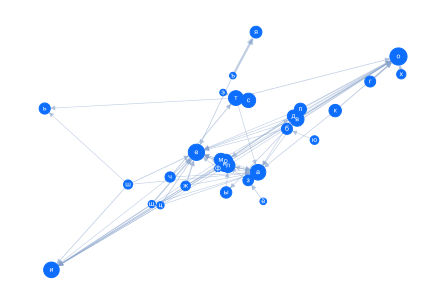

In [133]:
g = nx.DiGraph(directed=True)

n = 10

for l in need_symbs:
	pred = simple_model.counters[-1].predict_unif(l)
	pred = sorted_need_letters(pred, need_symbs)

	for i in range(n):
		p = pred[-1 - i]
		a = p[0]
		w = min(max(p[1], 0.2), 0.8) * 3

		g.add_edge(l, a, weight=w)

		if (pred[-1 - i - 1][1] < 0.2): break

weights = [g[u][v]['weight'] for u, v in g.edges]
node_sizes = [max(letter_counts[v[0]], 0.002)**0.5 * 1000 for v in g.degree]

options = {
    'node_color': '#0d6efd',
    'font_color': '#fff',
    'edge_color': '#89a4cb88',
    'font_size': 7, 
}

nx.draw(g, with_labels=True, width=weights, node_size=node_sizes, arrows=True, **options)

In [148]:
def discover_patterns(buffer, lim):
    buff = []
    for p in buffer:
        pred = simple_model.counters[-1].predict_unif(p[-1])
        pred = sorted_need_letters(pred, need_symbs)

        i = 0
        while pred[-1 - i][1] > lim:
            l = pred[-1 - i][0]
            if l not in p: buff.append(p + l)
            i += 1

    if buff == []: return buffer

    return discover_patterns(buff, lim) + buffer

def rate_poss(s):
    r = 1
    for i in range(1, len(s)):
        pr = match_to_letters(simple_model.counters[-1].predict_unif(s[i-1]))
        r += pr[s[i]]

    return r**0.5

patterns = discover_patterns(list(need_symbs), 0.12)
rated_patterns = [(p, rate_poss(p)) for p in patterns]
rated_patterns = sorted(rated_patterns, key=lambda x: x[1])

print(rated_patterns)



[('й', 1.0), ('ц', 1.0), ('у', 1.0), ('к', 1.0), ('е', 1.0), ('н', 1.0), ('г', 1.0), ('ш', 1.0), ('щ', 1.0), ('з', 1.0), ('х', 1.0), ('ъ', 1.0), ('ф', 1.0), ('ы', 1.0), ('в', 1.0), ('а', 1.0), ('п', 1.0), ('р', 1.0), ('о', 1.0), ('л', 1.0), ('д', 1.0), ('ж', 1.0), ('э', 1.0), ('я', 1.0), ('ч', 1.0), ('с', 1.0), ('м', 1.0), ('и', 1.0), ('т', 1.0), ('ь', 1.0), ('б', 1.0), ('ю', 1.0), ('ё', 1.0), ('мо', 1.0588571438954602), ('ва', 1.0604149836044756), ('ть', 1.0608327051686084), ('жа', 1.0616201731966397), ('фа', 1.063486890757111), ('чи', 1.0636050234414052), ('ве', 1.0643443338638667), ('фл', 1.066050131136463), ('ло', 1.06627300010325), ('фе', 1.0675851213211878), ('ци', 1.0677704712456766), ('ме', 1.070495023790207), ('ни', 1.0727831292842893), ('ла', 1.0731305235250617), ('зн', 1.073776330774708), ('до', 1.0737901785293682), ('бе', 1.0743765388907986), ('ча', 1.077569616419027), ('фо', 1.0792808538893166), ('да', 1.08020545576097), ('ри', 1.080231688608388), ('ре', 1.0810133372727133